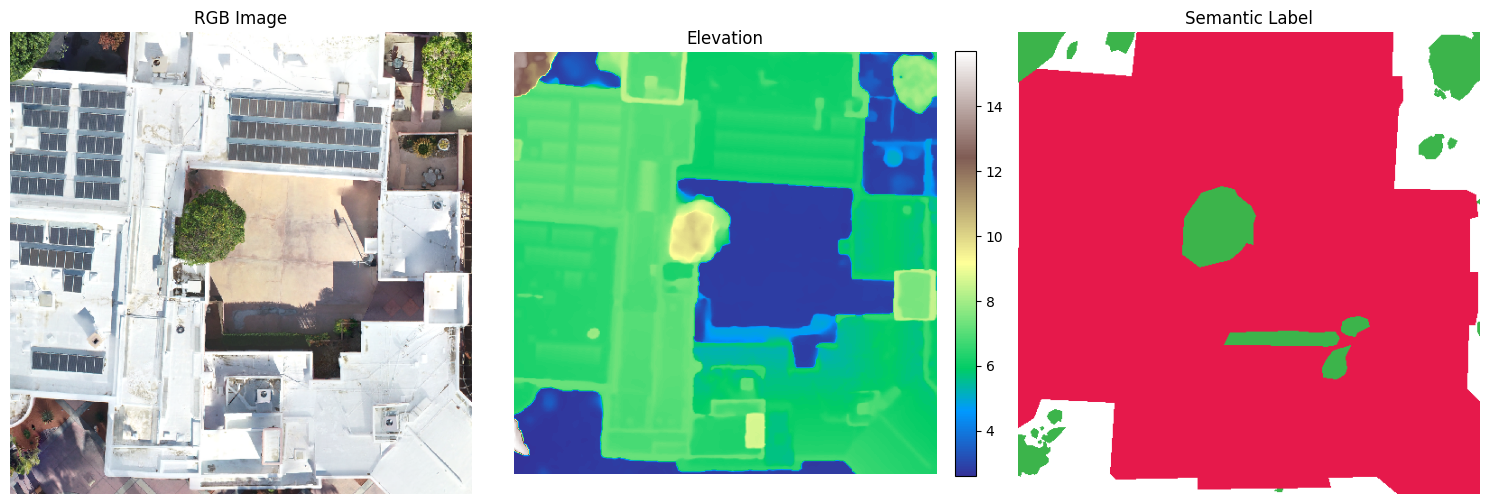

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Base filename (excluding suffix)
tile_base = "data/chipped/train/elevations/1d4fbe33f3_F1BE1D4184INSPIRE_1536_2048"

# Paths
elev_path = tile_base + "-elev.npy"
rgb_path = tile_base.replace("elevations", "images") + "-ortho.png"
label_path = tile_base.replace("elevations", "labels") + "-label.png"

# Check existence
if not all(os.path.exists(p) for p in [elev_path, rgb_path, label_path]):
    print("⚠️ One or more files not found.")
else:
    elev = np.load(elev_path)
    rgb = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
    label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(rgb)
    axes[0].set_title("RGB Image")
    axes[0].axis('off')

    im = axes[1].imshow(elev, cmap='terrain')
    axes[1].set_title("Elevation")
    axes[1].axis('off')
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    axes[2].imshow(label)
    axes[2].set_title("Semantic Label")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
from segmentation_models import Unet

model = Unet(
    backbone_name='resnet34',
    input_shape=(512, 512, 4),
    classes=6,
    activation='softmax',
    encoder_weights=None  # 🚨 must disable pretrained weights
)


In [ ]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(512, 512, 4), num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # --- Contracting Path ---
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # --- Bottleneck ---
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(c5)

    # --- Expansive Path ---
    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D((2,2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D((2,2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c9)

    # --- Output ---
    outputs = layers.Conv2D(num_classes, (1,1), activation='softmax')(c9)

    return models.Model(inputs=[inputs], outputs=[outputs])


In [ ]:
from libs.training import train_model

if __name__ == "__main__":
    train_model(input_type="rgb_elevation", batch_size=4, epochs=20)


ModuleNotFoundError: No module named 'libs.train_model'